In [1]:
!pip install --upgrade yfinance quantecon pandas_datareader interpolation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm

from interpolation import interp
from pandas_datareader import wb
from scipy.stats import norm, cauchy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

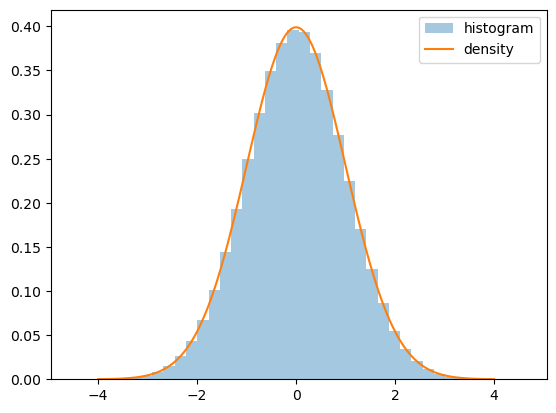

In [3]:
fig, ax = plt.subplots()
X = norm.rvs(size=1_000_000)
ax.hist(X, bins=40, alpha=0.4, label='histogram', density=True)
x_grid = np.linspace(-4, 4, 400)
ax.plot(x_grid, norm.pdf(x_grid), label='density')
ax.legend()
plt.show()

In [4]:
X.min(), X.max()

(-4.499553799985675, 4.606102407868684)

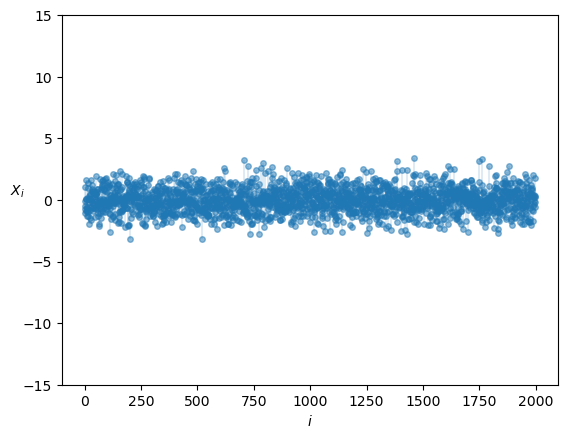

In [5]:
n = 2000
fig, ax = plt.subplots()
data = norm.rvs(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_ylim(-15, 15)
ax.set_xlabel('$i$')
ax.set_ylabel('$X_i$', rotation=0)
plt.show()

[*********************100%***********************]  1 of 1 completed

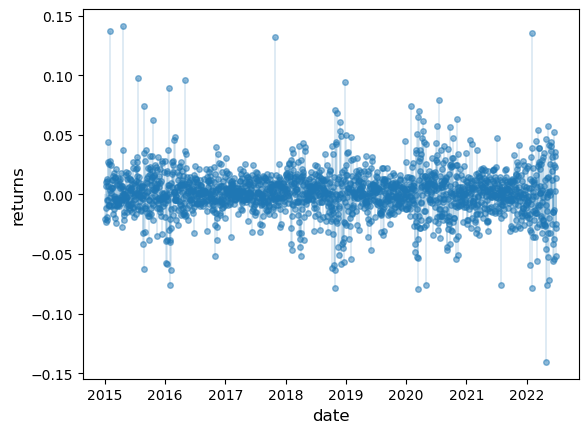

In [6]:
s = yf.download('AMZN', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

[*********************100%***********************]  1 of 1 completed

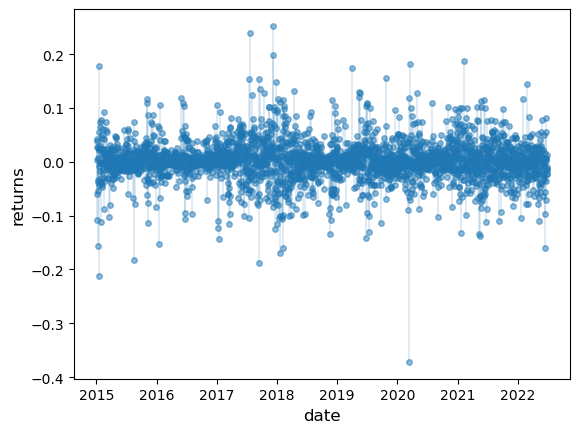

In [7]:
s = yf.download('BTC-USD', '2015-1-1', '2022-7-1')['Adj Close']
r = s.pct_change()

fig, ax = plt.subplots()

ax.plot(r, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(r.index, 0, r.values, lw=0.2)
ax.set_ylabel('returns', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

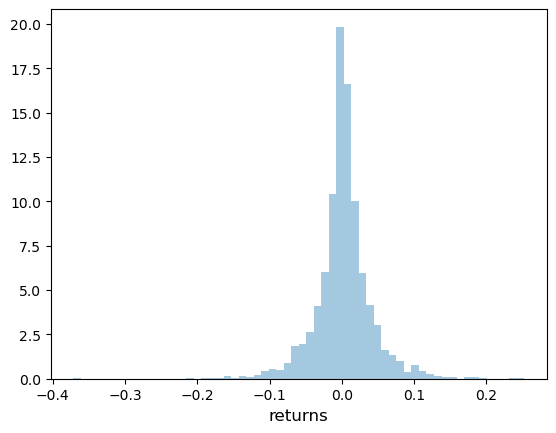

In [8]:
fig, ax = plt.subplots()
ax.hist(r, bins=60, alpha=0.4, label='bitcoin returns', density=True)
ax.set_xlabel('returns', fontsize=12)
plt.show()

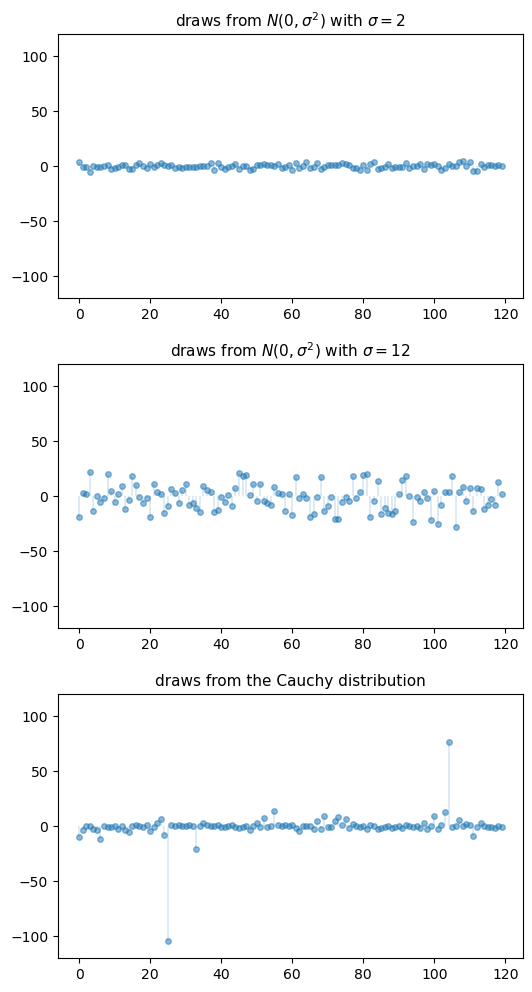

In [9]:
n = 120
np.random.seed(11)

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

for ax in axes:
    ax.set_ylim((-120, 120))

s_vals = 2, 12

for ax, s in zip(axes[:2], s_vals):
    data = np.random.randn(n) * s
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"draws from $N(0, \sigma^2)$ with $\sigma = {s}$", fontsize=11)

ax = axes[2]
distribution = cauchy()
data = distribution.rvs(n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)
ax.set_title(f"draws from the Cauchy distribution", fontsize=11)

plt.subplots_adjust(hspace=0.25)

plt.show()

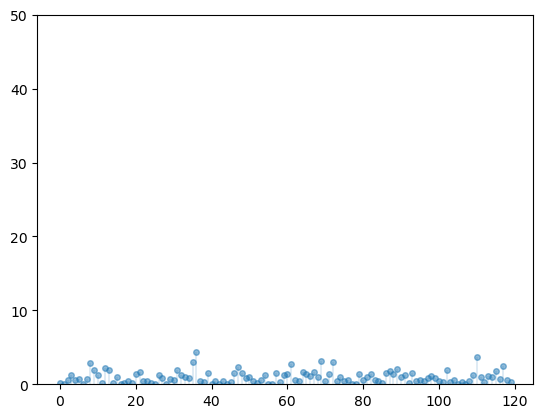

In [10]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 50))

data = np.random.exponential(size=n)
ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, data, lw=0.2)

plt.show()

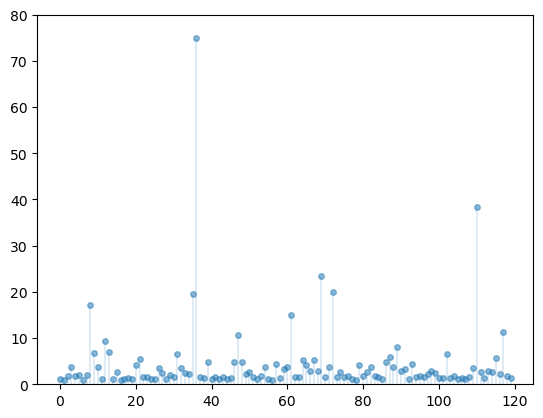

In [11]:
n = 120
np.random.seed(11)

fig, ax = plt.subplots()
ax.set_ylim((0, 80))
exponential_data = np.random.exponential(size=n)
pareto_data = np.exp(exponential_data)
ax.plot(list(range(n)), pareto_data, linestyle='', marker='o', alpha=0.5, ms=4)
ax.vlines(list(range(n)), 0, pareto_data, lw=0.2)

plt.show()

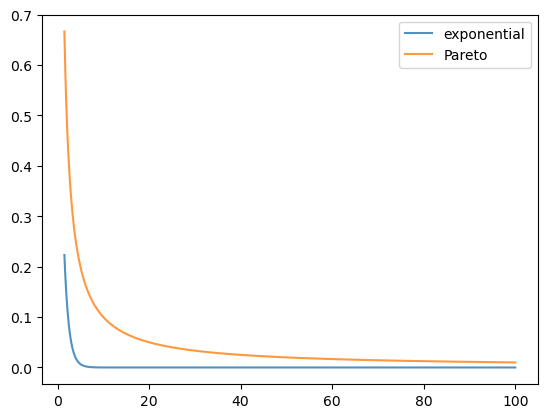

In [12]:
x = np.linspace(1.5, 100, 1000)
fig, ax = plt.subplots()
alpha = 1.0
ax.plot(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.plot(x, x**(- alpha), label='Pareto', alpha=0.8)
ax.legend()
plt.show()

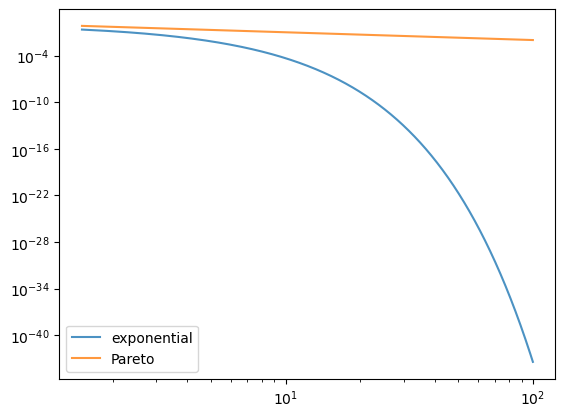

In [13]:
fig, ax = plt.subplots()
alpha = 1.0
ax.loglog(x, np.exp(- alpha * x), label='exponential', alpha=0.8)
ax.loglog(x, x**(- alpha), label='Pareto', alpha=0.8)
ax.legend()
plt.show()

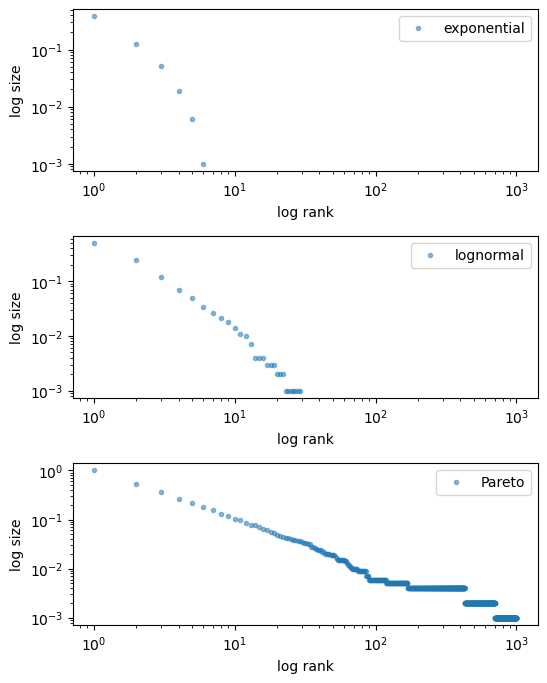

In [14]:
def eccdf(x, data):
    "Simple empirical CCDF function."
    return np.mean(data > x)

x_grid = np.linspace(1, 1000, 1000)
sample_size = 1000
np.random.seed(13)
z = np.random.randn(sample_size)

data_1 = np.random.exponential(size=sample_size)
data_2 = np.exp(z)
data_3 = np.exp(np.random.exponential(size=sample_size))

data_list = [data_1, data_2, data_3]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()
labels = ['exponential', 'lognormal', 'Pareto']

for data, label, ax in zip(data_list, labels, axes):

    ax.loglog(x_grid, [eccdf(x, data) for x in x_grid], 
        'o', markersize=3.0, alpha=0.5, label=label)
    ax.set_xlabel("log rank")
    ax.set_ylabel("log size")

    ax.legend()

fig.subplots_adjust(hspace=0.4)

plt.show()

In [15]:
def empirical_ccdf(data, 
                   ax, 
                   aw=None,   # weights
                   label=None,
                   xlabel=None,
                   add_reg_line=False, 
                   title=None):
    """
    Take data vector and return prob values for plotting.
    Upgraded empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # record fraction of sample above d
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: interp(data, fw, x)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)
    
    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params
    
    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"slope = ${a: 1.2f}$")
    if not xlabel:
        xlabel='log value'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("log prob.", fontsize=12)
        
    if label:
        ax.legend(loc='lower left', fontsize=12)
        
    if title:
        ax.set_title(title)
        
    return np.log(data), y_vals, p_vals

In [16]:
def extract_wb(varlist=['NY.GDP.MKTP.CD'], 
               c='all_countries', 
               s=1900, 
               e=2021, 
               varnames=None):
    if c == "all_countries":
        # Keep countries only (no aggregated regions)
        countries = wb.get_countries()
        countries_name = countries[countries['region'] != 'Aggregates']['name'].values
        c = "all"
    
    df = wb.download(indicator=varlist, country=c, start=s, end=e).stack().unstack(0).reset_index()
    df = df.drop(['level_1'], axis=1).transpose()
    if varnames is not None:
        df.columns = varnames
        df = df[1:]
    
    df1 =df[df.index.isin(countries_name)]
    return df1

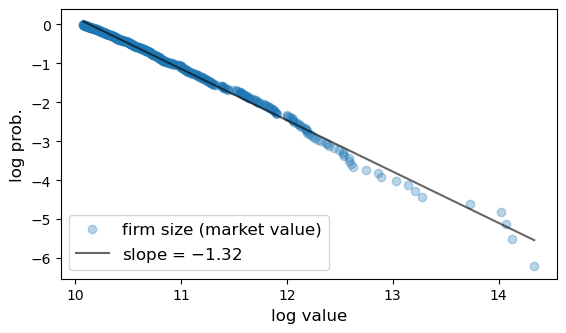

In [17]:
df_fs = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-global2000.csv')
df_fs = df_fs[['Country', 'Sales', 'Profits', 'Assets', 'Market Value']]
fig, ax = plt.subplots(figsize=(6.4, 3.5))

label="firm size (market value)"
top = 500 # set the cutting for top
d = df_fs.sort_values('Market Value', ascending=False)
empirical_ccdf(np.asarray(d['Market Value'])[:top], ax, label=label, add_reg_line=True)

plt.show()

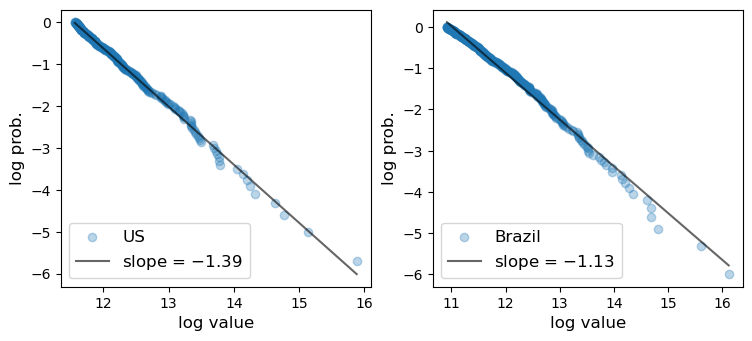

In [18]:
# import population data of cities in 2023 United States and 2023 Brazil from world population review
df_cs_us = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_us.csv')
df_cs_br = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/cities_brazil.csv')

fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

empirical_ccdf(np.asarray(df_cs_us["pop2023"]), axes[0], label="US", add_reg_line=True)
empirical_ccdf(np.asarray(df_cs_br['pop2023']), axes[1], label="Brazil", add_reg_line=True)

plt.show()

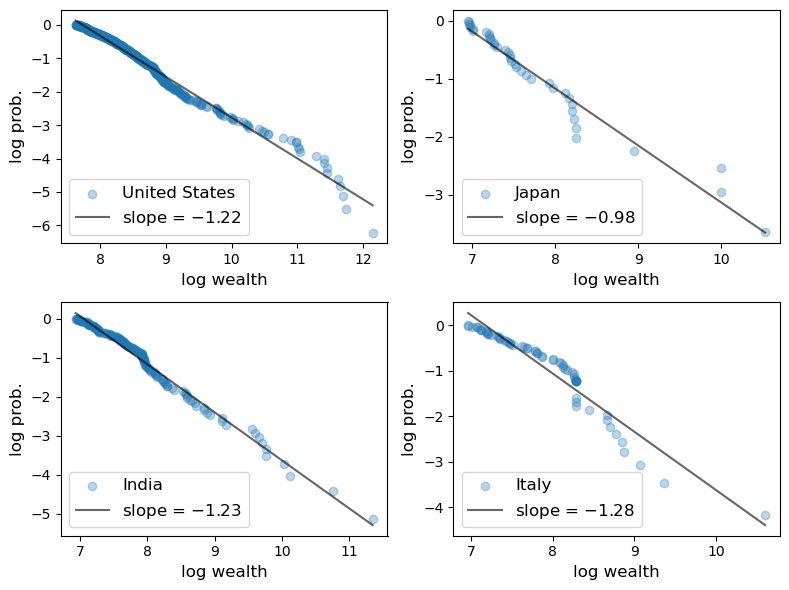

In [19]:
df_w = pd.read_csv('https://media.githubusercontent.com/media/QuantEcon/high_dim_data/main/cross_section/forbes-billionaires.csv')
df_w = df_w[['country', 'realTimeWorth', 'realTimeRank']].dropna()
df_w = df_w.astype({'realTimeRank': int})
df_w = df_w.sort_values('realTimeRank', ascending=True).copy()
countries = ['United States', 'Japan', 'India', 'Italy']  
N = len(countries)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for i, c in enumerate(countries):
    df_w_c = df_w[df_w['country'] == c].reset_index()
    z = np.asarray(df_w_c['realTimeWorth'])
    # print('number of the global richest 2000 from '+ c, len(z))
    top = 500           # cut-off number: top 500
    if len(z) <= top:    
        z = z[:top]

    empirical_ccdf(z[:top], axs[i], label=c, xlabel='log wealth', add_reg_line=True)
    
fig.tight_layout()

plt.show()

In [20]:
# get gdp and gdp per capita for all regions and countries in 2021

variable_code = ['NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD']
variable_names = ['GDP', 'GDP per capita']

df_gdp1 = extract_wb(varlist=variable_code, 
                     c="all_countries", 
                     s="2021", 
                     e="2021", 
                     varnames=variable_names)

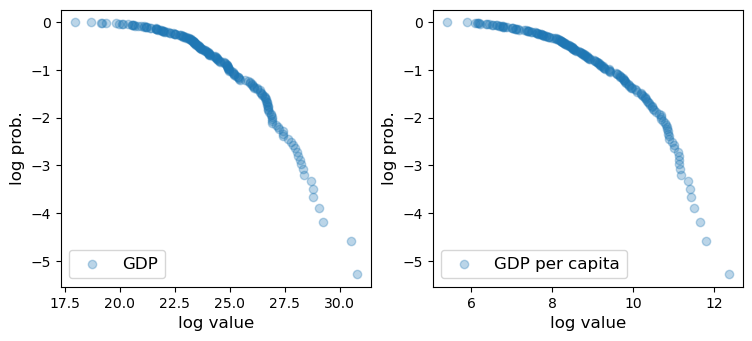

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.6))

for name, ax in zip(variable_names, axes):
    empirical_ccdf(np.asarray(df_gdp1[name]).astype("float64"), ax, add_reg_line=False, label=name)

plt.show()

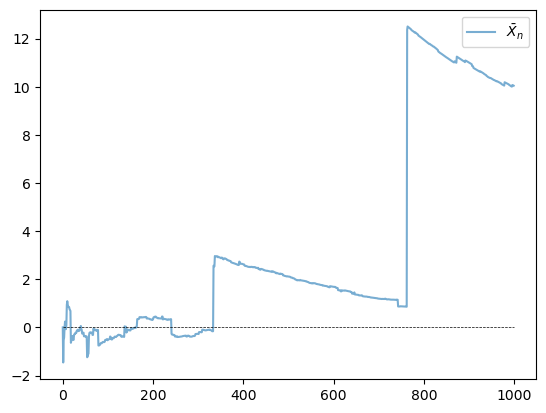

In [22]:
from scipy.stats import cauchy

np.random.seed(1234)
N = 1_000

distribution = cauchy()

fig, ax = plt.subplots()
data = distribution.rvs(N)

# Compute sample mean at each n
sample_mean = np.empty(N)
for n in range(1, N):
    sample_mean[n] = np.mean(data[:n])

# Plot
ax.plot(range(N), sample_mean, alpha=0.6, label='$\\bar{X}_n$')

ax.plot(range(N), np.zeros(N), 'k--', lw=0.5)
ax.legend()

plt.show()

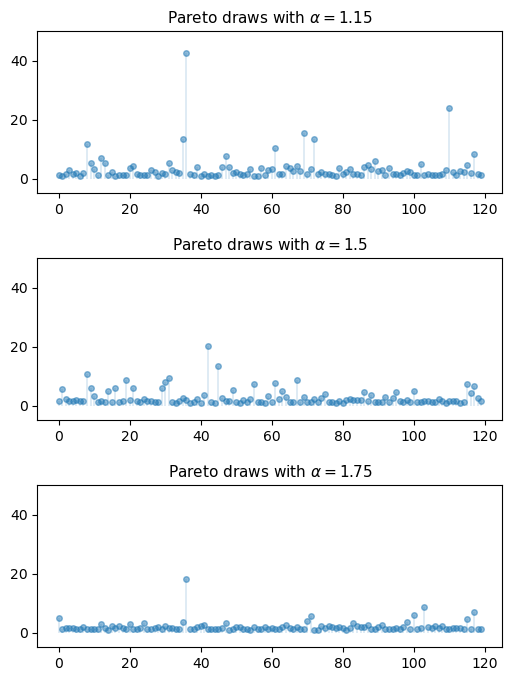

In [23]:
from scipy.stats import pareto

np.random.seed(11)

n = 120
alphas = [1.15, 1.50, 1.75]

fig, axes = plt.subplots(3, 1, figsize=(6, 8))

for (a, ax) in zip(alphas, axes):
    ax.set_ylim((-5, 50))
    data = pareto.rvs(size=n, scale=1, b=a)
    ax.plot(list(range(n)), data, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(list(range(n)), 0, data, lw=0.2)
    ax.set_title(f"Pareto draws with $\\alpha = {a}$", fontsize=11)

plt.subplots_adjust(hspace=0.4)

plt.show()

In [24]:
num_firms = 100_000
num_years = 10
tax_rate = 0.15
r = 0.05

β = 1 / (1 + r)    # discount factor

x_bar = 1.0
α = 1.05

def pareto_rvs(n):
    "Uses a standard method to generate Pareto draws."
    u = np.random.uniform(size=n)
    y = x_bar / (u**(1/α))
    return y

In [25]:
μ = np.log(2) / α
σ_sq = 2 * (np.log(α/(α - 1)) - np.log(2)/α)
σ = np.sqrt(σ_sq)

In [26]:
def tax_rev(dist):
    tax_raised = 0
    for t in range(num_years):
        if dist == 'pareto':
            π = pareto_rvs(num_firms)
        else:
            π = np.exp(μ + σ * np.random.randn(num_firms))
        tax_raised += β**t * np.sum(π * tax_rate)
    return tax_raised

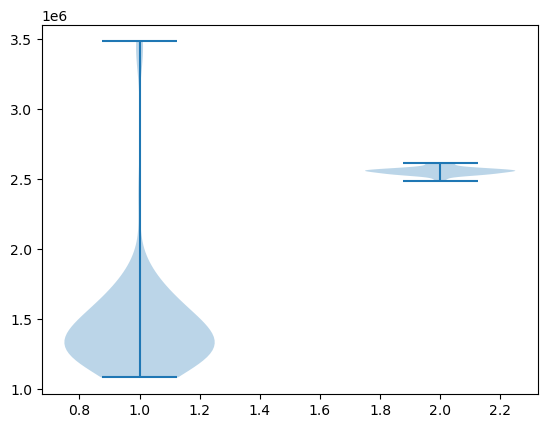

In [27]:
num_reps = 100
np.random.seed(1234)

tax_rev_lognorm = np.empty(num_reps)
tax_rev_pareto = np.empty(num_reps)

for i in range(num_reps):
    tax_rev_pareto[i] = tax_rev('pareto')
    tax_rev_lognorm[i] = tax_rev('lognorm')

fig, ax = plt.subplots()

data = tax_rev_pareto, tax_rev_lognorm

ax.violinplot(data)

plt.show()

In [28]:
tax_rev_pareto.mean(), tax_rev_pareto.std()

(1458729.0546623734, 406089.3613661567)

In [29]:
tax_rev_lognorm.mean(), tax_rev_lognorm.std()

(2556174.8615230713, 25586.44456513965)